# Proof of Concept
******
## Overview
In this section, we will provide a demo of our system.  

For easier reference, the outline of the steps taken in this notebook is as follows:
##### Steps:
1. Import and Install Required Libraries
2. Loading Training and Testing Datasets
3. Data Exploration
4. Data Pre-processing
5. Setting Up the Model
6. Model Evaluation
7. Model Predictions

The first step for this Proof of Concept (POC) will be to import and install required libraries. This will allow us to perform important tasks across this POC such as data preprocessing, data visualisation, the creation of deep learning models and model evaluation. The first step also involves initialising any variables that we may need across multiple parts of the code. Next, we are required to load the data used to train and validate the predictions given by the model. Training datasets are categorised into two types, *unperturbed* and *perturbed*. The *perturbed* training dataset contains the images from the *unpertubed* dataset with digital makeup on. <br>
...
***************

## Step 1: Import and Install Required Libraries

In [1]:
# %pip install opencv-python
# %pip install matplotlib
# %pip install keras
# %pip install seaborn
# %pip install sklearn

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout 
import seaborn as sns
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from ipykernel import kernelapp as app

In [3]:
epochs = 300
batch_size = 64
img_size = 224
labels = ['female', 'male']

******************
## Step 2: Load Training and Testing Datasets

In [4]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=list)

In [5]:
train = get_data('preprocessing/train_data')
val = get_data('preprocessing/val_data')
train_pert = get_data('preprocessing/makeup')

*********************
## Step 3: Data Exploration

In [6]:
def plot_dataset_ratio(l, count, data, femaleLabel, maleLabel):
    for i in data:
        if (i[1] == 0):
            l.append(femaleLabel)      
        else:
            l.append(maleLabel)
        count += 1

<AxesSubplot:>

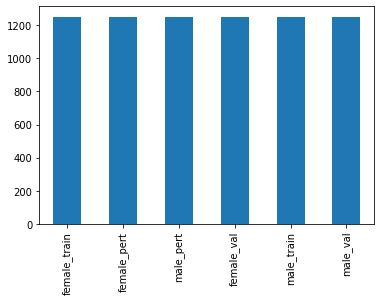

In [7]:
l = []
train_count = 0
val_count = 0
train_pert_count = 0

plot_dataset_ratio(l, train_count, train, "female_train", "male_train")
plot_dataset_ratio(l, train_pert_count, train_pert, "female_pert", "male_pert")
plot_dataset_ratio(l, val_count, val, "female_val", "male_val")

pd.value_counts(pd.Series(data=l)).plot.bar()

**********************
## Step 4: Data Pre-processing

In [8]:
x_train = []
y_train = []
x_train_pert = []
y_train_pert = []
x_val = []
y_val = []

# Unpertubed Dataset
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# Perturbed Dataset
for feature, label in train_pert:
    x_train_pert.append(feature)
    y_train_pert.append(label)
x_train_pert = np.array(x_train_pert) / 255
x_train_pert.reshape(-1, img_size, img_size, 1)
y_train_pert = np.array(y_train_pert)

# Validation Dataset
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
x_val = np.array(x_val) / 255
x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

**********************
## Step 5: Setting Up the Model
- Explain layer by layer
    - number of epochs, batch size
    - activation functions
    - dropout to reduce overfitting
    - why it is best practice for later layers to have an increasing amount of filters

In [9]:
def createModel():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(224,224,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    opt = Adam(lr=0.000001)
    model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
    
    return model

In [10]:
# model.summary()

### Without Pertubations

In [11]:
model = createModel()
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')
history = model.fit(x_train,y_train,epochs = epochs ,
                    batch_size=batch_size,
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])

Epoch 1/300
40/40 [==============================] - 9s 153ms/step - loss: 0.7067 - accuracy: 0.5073 - val_loss: 0.6916 - val_accuracy: 0.5340

Epoch 00001: loss improved from inf to 0.70452, saving model to model_best_weights.h5
Epoch 2/300
40/40 [==============================] - 5s 124ms/step - loss: 0.6879 - accuracy: 0.5448 - val_loss: 0.6891 - val_accuracy: 0.5644

Epoch 00002: loss improved from 0.70452 to 0.69235, saving model to model_best_weights.h5
Epoch 3/300
40/40 [==============================] - 5s 124ms/step - loss: 0.6932 - accuracy: 0.5355 - val_loss: 0.6872 - val_accuracy: 0.5768

Epoch 00003: loss improved from 0.69235 to 0.69108, saving model to model_best_weights.h5
Epoch 4/300
40/40 [==============================] - 5s 123ms/step - loss: 0.6907 - accuracy: 0.5352 - val_loss: 0.6856 - val_accuracy: 0.5768

Epoch 00004: loss improved from 0.69108 to 0.68851, saving model to model_best_weights.h5
Epoch 5/300
40/40 [==============================] - 5s 124ms/step -

### With Pertubations

In [12]:
model_pert = createModel()
checkpoint_pert = ModelCheckpoint('model_best_weights_pert.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')
history_pert = model.fit(x_train_pert,y_train_pert,epochs = epochs ,
                    batch_size=batch_size,
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint_pert])

Epoch 1/300
40/40 [==============================] - 6s 139ms/step - loss: 0.5293 - accuracy: 0.7336 - val_loss: 0.5886 - val_accuracy: 0.7048

Epoch 00001: loss improved from inf to 0.52929, saving model to model_best_weights_pert.h5
Epoch 2/300
40/40 [==============================] - 5s 125ms/step - loss: 0.5191 - accuracy: 0.7520 - val_loss: 0.5888 - val_accuracy: 0.7096

Epoch 00002: loss improved from 0.52929 to 0.51911, saving model to model_best_weights_pert.h5
Epoch 3/300
40/40 [==============================] - 5s 125ms/step - loss: 0.5268 - accuracy: 0.7444 - val_loss: 0.5887 - val_accuracy: 0.7060

Epoch 00003: loss did not improve from 0.51911
Epoch 4/300
40/40 [==============================] - 5s 124ms/step - loss: 0.5215 - accuracy: 0.7452 - val_loss: 0.5865 - val_accuracy: 0.7116

Epoch 00004: loss did not improve from 0.51911
Epoch 5/300
40/40 [==============================] - 5s 124ms/step - loss: 0.5230 - accuracy: 0.7448 - val_loss: 0.5863 - val_accuracy: 0.7140



********
## Step 6: Model Evaluation and Predictions

Discussion points:
- Compare Accuracy and Loss
- Compare Confusion Matrices
- Why the precision, recall and f1-score are similar when the data is unpertubated.
- Why the recall is so consistently high when the data is pertubated.


In [22]:
target_names = ['Female (Class 0)','Male (Class 1)']
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory("preprocessing/val_data",
                                                            target_size=(224, 224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

def plot_train_val_acc_loss(history, noTrain, noVal):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
def gen_cm(model, num_of_val_samples):
    Y_pred = model.predict(validation_generator, 2500 // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    confusion_matrix_array = confusion_matrix(validation_generator.classes, y_pred)
    print(confusion_matrix_array)
    df_cm = pd.DataFrame(confusion_matrix_array, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
    plt.show()
    return y_pred

Found 2500 images belonging to 2 classes.


### Without Pertubation

#### Accuracy and Loss

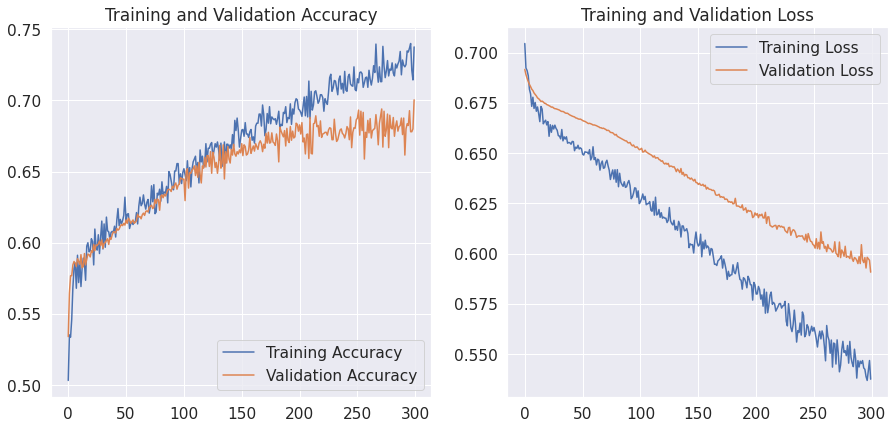

In [19]:
plot_train_val_acc_loss(history, train_count, val_count)

#### Confusion Matrix

Confusion Matrix
[[735 515]
 [762 488]]


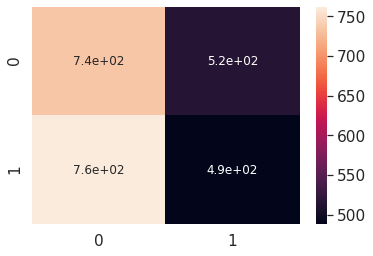

In [23]:
y_pred = gen_cm(model, val_count)

### Classification Report

In [24]:
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1))

                  precision    recall  f1-score   support

Female (Class 0)       0.49      0.59      0.54      1250
  Male (Class 1)       0.49      0.39      0.43      1250

        accuracy                           0.49      2500
       macro avg       0.49      0.49      0.48      2500
    weighted avg       0.49      0.49      0.48      2500



### With Pertubation

#### Accuracy and Loss

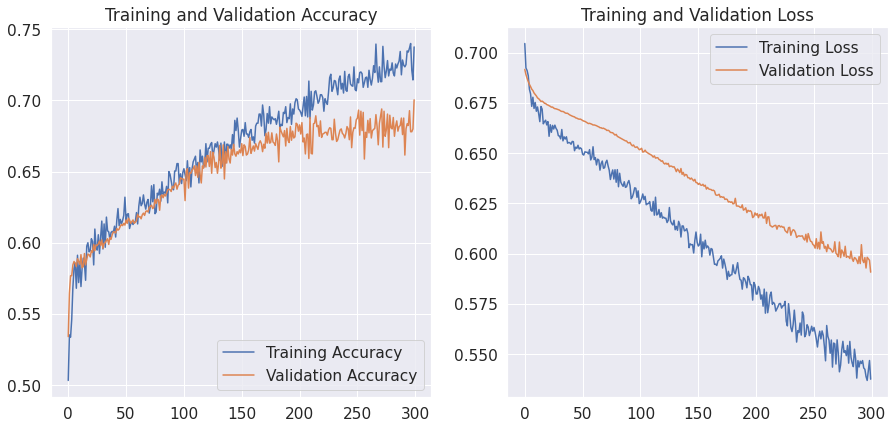

In [25]:
plot_train_val_acc_loss(history, train_pert_count, val_count)

#### Confusion Matrix

Confusion Matrix
[[993 257]
 [993 257]]


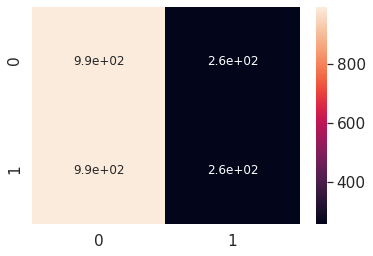

In [26]:
y_pred_pert = gen_cm(model_pert, val_count)

#### Classification Report

In [27]:
print(classification_report(validation_generator.classes, y_pred_pert, target_names=target_names, zero_division=1))

                  precision    recall  f1-score   support

Female (Class 0)       0.50      0.79      0.61      1250
  Male (Class 1)       0.50      0.21      0.29      1250

        accuracy                           0.50      2500
       macro avg       0.50      0.50      0.45      2500
    weighted avg       0.50      0.50      0.45      2500



********
## Step 7: Making Predictions

Through analysis of the images below, it seems that when the data is pertubated with make up on, it is more likely that the model will predict that the subject is a female. 

Speculations:
- Adding some make up to classified male faces may improve gender biasness in AI
- Removing make up features from females may improve gender biasness in AI

### Without Pertubation

In [28]:
def predictImage(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

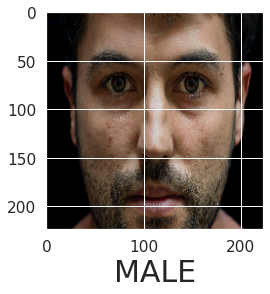

In [29]:
predictImage("random.jpeg")

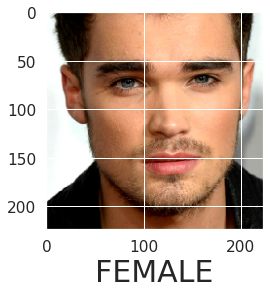

In [30]:
predictImage("celeb.jpg")

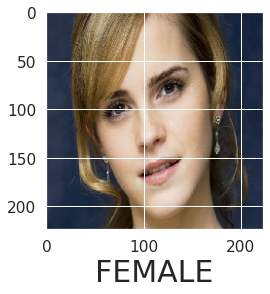

In [31]:
predictImage("emma.jpg")

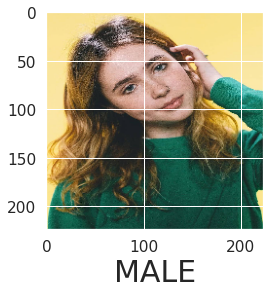

In [32]:
predictImage("clairo.jpeg")

### With Pertubation

In [33]:
def predictImagePert(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model_pert.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

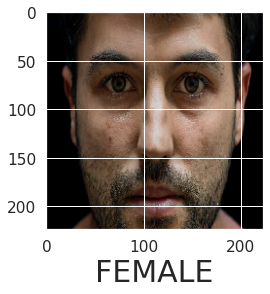

In [34]:
predictImagePert("random.jpeg")

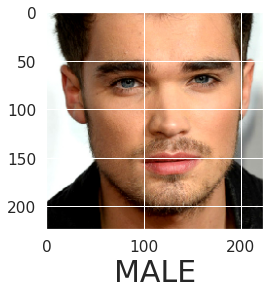

In [35]:
predictImagePert("celeb.jpg")

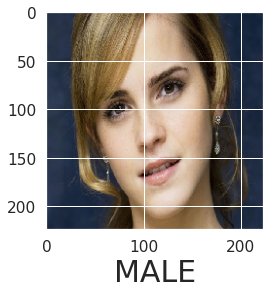

In [36]:
predictImagePert("emma.jpg")

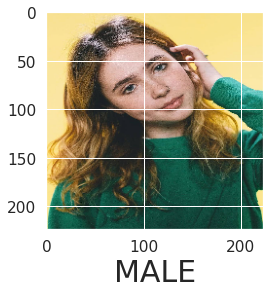

In [37]:
predictImagePert("clairo.jpeg")